# Сбор данных

Первый этап любой работы с данными - это их сбор. Тут возможны варианты в зависимости от ситуации и от глобальной задачи. Три общих подхода к сбору данных на Python:
1. скрейпинг, т.е. извлечение данных с веб-страниц
2. парсинг данных по API
3. использование уже написанных библиотек
4. сбор собственного корпуса вручную

# 0. Инициализация

In [1]:
import os.path

def check_if_file_exists(filename: str) -> None:
    if not os.path.exists(filename):
        raise FileNotFoundError(f'{filename} file not found!')
    print(f'[OK] {filename} loaded')

## .env

Для получения секретной информации будем использовать `.env` файл

In [2]:
%%capture
!pip install python-dotenv

In [3]:
from dotenv import dotenv_values

In [5]:
check_if_file_exists('.env')
env_config = dotenv_values('.env')

[OK] .env loaded


## git

Устанавливаем глобальные настройки гита

In [6]:
!git config --global user.email "evlko.oklve@gmail.com"
!git config --global user.name "Google Colab"

Название репозиторию и ссылка на него

In [7]:
repo_name = 'CS-250'
repo = f'github.com/evlko/{repo_name}.git'

Клонируем репозиторий

In [8]:
!git clone https://@$repo

Cloning into 'CS-250'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 106 (delta 44), reused 68 (delta 16), pack-reused 0
Receiving objects: 100% (106/106), 11.30 KiB | 5.65 MiB/s, done.
Resolving deltas: 100% (44/44), done.


Переходим в папку репозитория

In [9]:
%cd /content/$repo_name

/content/CS-250


Добавляем `personal token` с возможностью подключения к `public repo`

In [10]:
git_token = env_config['GIT_TOKEN']

## dvc

Для использования data version control и работы с данными через gdrive необходимо установить соответсвующие библиотеки

In [11]:
%%capture
!pip install dvc dvc_gdrive

Если dvc не инициализирован (в склонированном репозитории он уже есть), то:
* `!dvc init -f` - инициализируем dvc
* `!dvc remote add --default data gdrive://19MB_S_nLaUlE7FFMNB0ViMFtWl83UuC-` - подключаем гугл папку
* `!dvc remote modify data gdrive_use_service_account true` - включаем доступ через **сервисный аккаунт**

Добавляем `dvc` в `git`:
* `!git add --all`
* `!git commit -m "Init DVC"`
* `!git push https://$git_token@github.com/evlko/$repo_name.git`

Указываем название конфиг файла (сервисного аккаунта)

In [12]:
dvc_local_config = "dvc-local-config.json"

Проверяем, что файл есть в репозитории.

In [13]:
check_if_file_exists(dvc_local_config)

[OK] dvc-local-config.json loaded


Добавляем локальные данные в `dvc` про сервисный аккаунт.

In [14]:
!dvc remote modify data --local gdrive_service_account_json_file_path $dvc_local_config

Переходим в папку с данными, так как работа будет исключительно с ними

In [15]:
%cd data

/content/CS-250/data


Подгружаем все данные из `dvc`

In [16]:
%%capture
!dvc pull

Класс для создания коммитов в `git` и `dvc`

In [17]:
from datetime import date
import subprocess as cmd


class Commiter:
    def __init__(self, git_token: str, repo_name: str) -> None:
        self.__git_token = git_token
        self.__repo_name = repo_name


    @staticmethod
    def strtime() -> str:
        return date.today().strftime('%d_%m_%Y')


    @classmethod
    def git_dvc_commit_args(cls, filename: str) -> tuple:
        return (filename + '.dvc', f'[dvc] {filename} | {cls.strtime()}')


    @staticmethod
    def dvc_commit(filename: str) -> None:
        cmd.run(f'dvc add {filename}', check=True, shell=True)
        cmd.run(f'dvc push', check=True, shell=True)


    def git_commit(self, filename: str, commit_message: str) -> None:
        cmd.run(f'git add {filename}', check=True, shell=True)
        cmd.run(f'git commit -m "{commit_message}"', check=True, shell=True)
        cmd.run(f'git push https://{self.__git_token}@github.com/evlko/{self.__repo_name}.git', check=True, shell=True)


    def commit_json(self, name: str) -> None:
        name += '.json'
        self.dvc_commit(name)
        self.git_commit(*self.git_dvc_commit_args(name))


    def commit_pandas(self, pandas_obj: object, name: str) -> None:
        name += '.csv'
        pandas_obj.to_csv(name, index=False)
        self.dvc_commit(name)
        self.git_commit(*self.git_dvc_commit_args(name))



commiter = Commiter(git_token, repo_name)

## Extra Functions

In [18]:
import warnings

warnings.filterwarnings('ignore', message="registration of accessor <class '__main__.CustomAccessor'>")
warnings.simplefilter(action='ignore', category=FutureWarning)

Расширяем класс `pd.DataFrame`:
* `to_csv_with_time` - сохраняет `df` с расширением в `.csv` в папку данных и добавляет текущую дату к названию

In [19]:
import pandas as pd

@pd.api.extensions.register_dataframe_accessor('custom')
class CustomAccessor:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def to_csv_with_time(self, name):
        daystr = date.today().strftime('%d_%m_%Y')
        self._obj.to_csv(f'{name}_{daystr}.csv', index=False)

Конвертер для словарей и json'а
* `to_json` - сохраняет словарь в указанный файл
* `from_json` - подгружает словарик из заданного файла


In [20]:
import json

class JsonDictConverter:
    @staticmethod
    def to_json(dictionary: dict, json_name: str, timed=False) -> None:
        day = date.today().strftime('_%d_%m_%Y') if timed else ''
        filename = f'{json_name}{day}.json'
        with open(filename, 'w') as file:
            json.dump(dictionary, file)


    @staticmethod
    def from_json(json_name: str) -> dict:
        with open(f'{json_name}.json', 'r') as file:
            return dict(json.load(file))

converter = JsonDictConverter()

Заведем декоратор, который будет копировать все словари в аргументах функции, чтобы избежать ссылки на одну ячейку памяти и спокойно модифицировать словари

In [21]:
def copy_dicts_to_local_scope(func):
    def wrapper(*args, **kwargs):
        args = [arg if type(arg) != dict else arg.copy() for arg in args]
        return func(*args, **kwargs)
    return wrapper

# Упражнение 1. Работа с API

Можно выполнять в мини-группах из 2-3 человек.

Есть проект "Конструктор ОП" http://op.itmo.ru

## Задание 1.0

Доступ к контенту появляется после регистрации. Можно войти через ИСУ, первый вход = регистрация. Для целей лабораторной работы можно либо создать пользователя, либо воспользоваться тестовым.

В процессе работы нужно будет получить данные по API. Собрать по этим данным датасет (например, можно воспользоваться библиотекой pandas). После провести первичный анализ и сделать визуализации.

In [22]:
import requests

In [23]:
url = "https://op.itmo.ru/auth/token/login"
auth_data = {"username": env_config['API_USER'], "password": env_config['API_PASSWORD']}

In [24]:
token_txt = requests.post(url, auth_data).text

In [25]:
token = json.loads(token_txt)["auth_token"]
headers = {'Content-Type': "application/json", 'Authorization': "Token " + token}

## Задание 1.1 Получить идентификаторы всех учебных планов, имеющихся в op.itmo.ru

In [26]:
api_url = "https://op.itmo.ru/api"
academic_plan_ids_csv_name = 'academic_plan_id'

In [27]:
import math
import threading
from tqdm import tqdm


def get_academic_plans_ids(api_url: str, headers: dict) -> set:
    url = f'{api_url}/record/academic_plan/academic_wp_description/all'
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(response)
        return

    response_json = response.json()
    pages_count = math.ceil(response_json['count'] / len(response_json['results']))

    print(f"Found {pages_count} pages")
    ids = set()

    def get_page(page: int):
        nonlocal url, headers
        session = requests.Session()
        response = session.get(url, headers=headers, params={"page": page})
        response_json = response.json()
        for row in response_json['results']:
            ids.add(row['id'])
        print('|', end='')

    threads_before = threading.active_count()
    print("Collecting pages:", end=' ')

    for page in range(1, pages_count + 1):
        threading.Thread(target=get_page, args=(page,)).start()

    while True:
        if threading.active_count() == threads_before:
            break

    return ids

In [28]:
def get_data(data_name=None, file_type='csv', api_function=None, **kwargs):
    if data_name is None:
        return api_function(**kwargs)
    else:
        return pd.read_csv(f'{data_name}.csv') if file_type == 'csv' else converter.from_json(data_name)

In [ ]:
# Get new ids from API:
# ids = get_data(api_function=get_academic_plans_ids, api_url=api_url, headers=headers)
# ids = list(ids)

Found 60 pages

In [29]:
# User stored ids in DVC:
ids = get_data(academic_plan_ids_csv_name)['academic_plan_id'].tolist()

Проверим сколько id получилось добыть (в прошлый раз их было 597, сегодня уже 598!)

In [30]:
len(ids)

598

Можем сохранить полученные id'шники как локально (дописав текущую дату), так и удаленно (через dvc)

In [31]:
df_aps = pd.DataFrame(ids, columns=['academic_plan_id'])
df_aps.custom.to_csv_with_time('academic_plan_id')
df_aps

,academic_plan_id
0,6796
1,6797
2,6798
3,6799
4,6800
...,...
593,7501
594,7502
595,7503
596,7504


In [ ]:
# Save collected data
# commiter.commit_pandas(df_aps, 'academic_plan_id')

Получаем 3 файла:
1. `name.csv` - `csv` файл, который идет в `dvc`
2. `name_[date].csv` - `csv` файл с датой, пригодится как локальная копия
3. `name.csv.dvc` - `dvc` конфиг для файла

## Задание 1.2 По этим планам получить детальное описание

In [ ]:
# https://op.itmo.ru/api/academicplan/detail/<id>

# пример вызова https://op.itmo.ru/api/academicplan/detail/7292

Структура ответа: 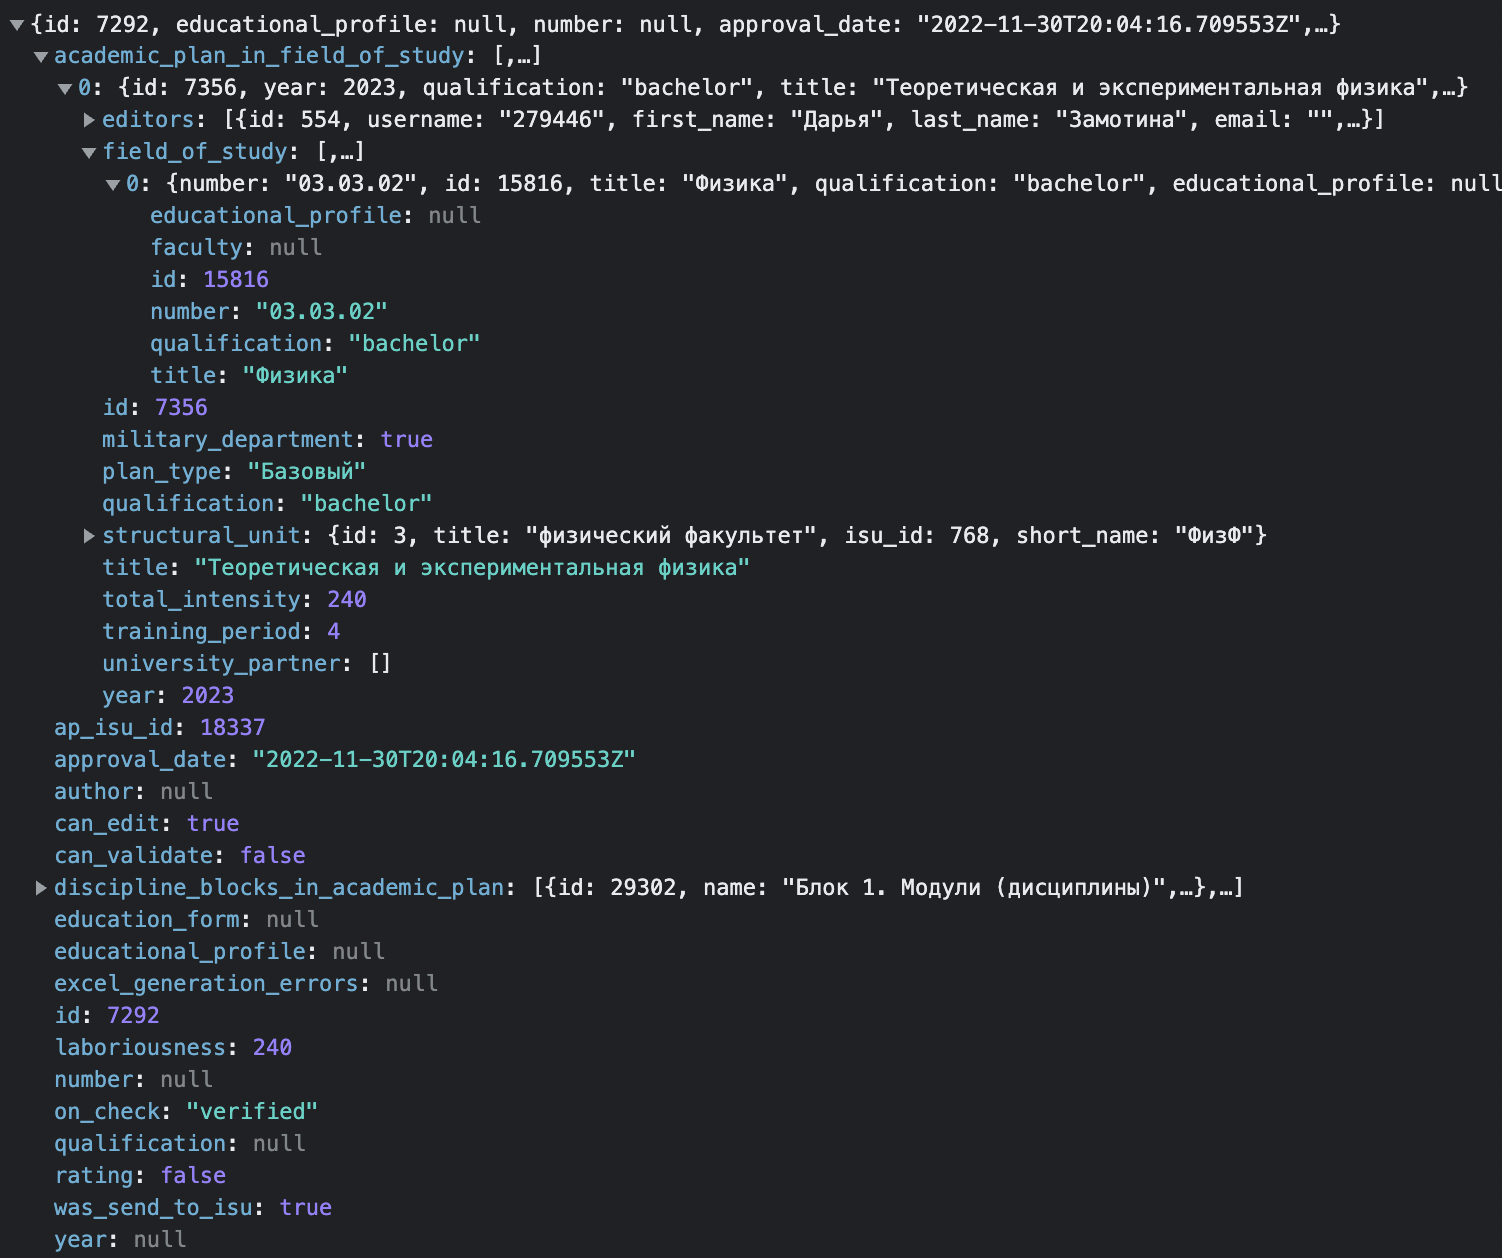

На основе описаний сделать датасет, состоящий из одной или нескольких таблиц. Добавить время скачивания.

Учтите, что количество планов более 580, скачиваться может очень долго, поэтому нужно правильно распределить обязанности.

In [ ]:
def get_academic_plan_details(api_url: str, headers: dict, ids: list) -> dict:
    url = f'{api_url}/academicplan/detail/'
    result = {}

    def get_plan(id: int):
        nonlocal url, headers
        session = requests.Session()
        response = session.get(url + str(id), headers=headers)
        result[id] = response.json()
        print('|', end='')


    print("Collecting plans:", end=' ')

    for start in range(0, len(ids), 50):
        threads_before = threading.active_count()
        print("\n               ", end=' ')
        for id in ids[start:min(start + 50, len(ids))]:
            threading.Thread(target=get_plan, args=(id,)).start()
        while True:
            if threading.active_count() == threads_before:
                break

    return result

In [ ]:
# Update data via API:
# all_details = get_data(api_function=get_academic_plan_details, api_url=api_url, headers=headers, ids=[7350])

                |

In [ ]:
# User stored data in DVC:
all_details = get_data('all_details', file_type='json')

In [ ]:
len(all_details)

598

In [ ]:
# converter.to_json(dictionary=all_details, json_name='all_details', timed=True)
# converter.to_json(dictionary=all_details, json_name='all_details', timed=False)
# commiter.commit_json('all_details')

Посмотрим на структуру ответа (дерево). Каждый объект состоит из:

- `id` - идентификатор
- `approval_date` - дата подтверждения
- `ap_isu_id` - идентификатор isu
- `laboriousness` - трудоемкость
- `was_send_to_isu` - был ли отправлен в isu
- `academic_plan_in_field_of_study_id` - индентификатор образовательной программы
* `educational_profile` — всегда / почти всегда пустое поле
* `number` — всегда пустое поле
* `year` — всегда пустое поле
* `education_form` — всегда пустое поле
* `qualification` — всегда пустое поле
* `author` — всегда пустое поле
* `on_check` — статус
* `excel_generation_errors` — **список** ошибок при создании excel файла
* `can_edit` — всегда False
* `can_validate` — всегда False
* `rating` — рейтинг
* `discipline_blocks_in_academic_plan` — **список** блоков дисциплин в уч плане
* `academic_plan_in_field_of_study` — **список** уч планов внутри оп

Разобьем все данные на несколько таблиц:
1. Учебные планы (`academic_plans`)
2. Образовательные программы (`academic_plans_in_field_of_study`)
3. Направления (`fields_of_study`)
4. Структруные подразделения (`structural_units`)
5. Редакторы (`editors`)

Таблицы будем связывать через id'шники сущностей. Дополнительно уберем ненужные колонки.

In [ ]:
class DataExtractor():
    def __init__(self, data: dict, update=True):
        self.data = data
        self.df_names = ['academic_plans', 'academic_plans_in_field_of_study', 'structural_units', 'fields_of_study', 'editors']
        self.dfs = {}
        if update:
            self.dfs['academic_plans'] = self.extract_academic_plans()
            self.dfs['academic_plans_in_field_of_study'] = self.extract_academic_plans_in_field_of_study()
            self.dfs['fields_of_study'] = self.extract_fields_of_study()
            self.dfs['structural_units'] = self.extract_structural_units()
            self.dfs['editors'] = self.extract_editros()
        else:
            for df_name in self.df_names:
                self.dfs[df_name] = pd.read_csv(f'{df_name}.csv')

    def get_entity_id(self, entity):
        try:
            if type(entity) == dict:
                return entity['id']
            else:
                return [e['id'] for e in entity]
        except:
            return None

    def assign_entity_id(self, df, columns, drop=True, suffix='_id'):
        for col in columns:
            df[col+suffix] = df.apply(lambda x: self.get_entity_id(x[col]), axis=1)
        if drop: df = df.drop(columns=columns)
        return df

    def clear_df(self, df, unused_columns=[]):
        df = df.drop(columns=unused_columns)
        df = df.dropna(how='all', axis=1)
        df = df.dropna(how='all', axis=0)
        return df

    def explode_df(self, df, explode_columns):
        for col in explode_columns:
            df = df.explode(col)
        return df

    def unique_df_by_id(self, df):
        df = df.drop_duplicates(subset=['id'], keep='first')
        df = df.reset_index(drop=True)
        return df

    def extract_academic_plans(self, drop_extra=True):
        df = pd.DataFrame(self.data.values())
        unused_columns = ['discipline_blocks_in_academic_plan', 'excel_generation_errors']
        explode_columns = ['educational_profile', 'academic_plan_in_field_of_study']
        ids_columns = ['academic_plan_in_field_of_study']

        df = self.clear_df(df, unused_columns)
        df = self.explode_df(df, explode_columns)
        df = self.assign_entity_id(df, ids_columns, drop=drop_extra)

        return df

    def extract_academic_plans_in_field_of_study(self, clear_extra=True, drop_extra=True):
        df_academic_plans = self.extract_academic_plans(drop_extra=False)
        df = pd.json_normalize(df_academic_plans['academic_plan_in_field_of_study'])

        explode_columns = ['field_of_study']
        ids_columns = ['field_of_study', 'editors']

        df = self.explode_df(df, explode_columns)
        df = self.assign_entity_id(df, ids_columns, drop_extra)

        df['structural_unit_id'] = df['structural_unit.id']
        unused_columns = [col for col in df if col.startswith('structural_unit.')]

        if clear_extra: df = self.clear_df(df, unused_columns)

        return df

    def extract_fields_of_study(self):
        df_academic_plan_in_field_of_study = self.extract_academic_plans_in_field_of_study(False, False)
        df = pd.json_normalize(df_academic_plan_in_field_of_study['field_of_study'])
        df = self.unique_df_by_id(df)

        return df

    def extract_structural_units(self):
        df_academic_plan_in_field_of_study = self.extract_academic_plans_in_field_of_study(False)
        structural_unit_cols = [col for col in df_academic_plan_in_field_of_study if col.startswith('structural_unit.')]
        df = df_academic_plan_in_field_of_study[structural_unit_cols]

        df.columns = df.columns.str.replace('structural_unit.', '', regex=False)
        df = self.clear_df(df)
        df = self.unique_df_by_id(df)

        return df

    def extract_editros(self):
        df_academic_plan_in_field_of_study = self.extract_academic_plans_in_field_of_study(False, False)
        df = df_academic_plan_in_field_of_study[['editors']]

        explode_columns = ['editors']
        df = self.explode_df(df, explode_columns)

        df = pd.json_normalize(df['editors'])

        df = self.clear_df(df)
        df = self.unique_df_by_id(df)

        return df

    def commit_to_dvc(self, files, commiter):
        for file in files:
            commiter.commit_pandas(self.dfs[file], file)

    def create_local_copies(self, files):
        for file in files:
            self.dfs[file].custom.to_csv_with_time(file)

In [ ]:
data_extractor = DataExtractor(all_details, update=True)

## Полученные сырые данные

### Учебные планы (`academic_plans`)

In [ ]:
df_academic_plans = data_extractor.dfs['academic_plans']
df_academic_plans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598 entries, 0 to 597
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  598 non-null    int64  
 1   educational_profile                 3 non-null      object 
 2   approval_date                       598 non-null    object 
 3   year                                4 non-null      object 
 4   education_form                      3 non-null      object 
 5   qualification                       9 non-null      object 
 6   author                              3 non-null      float64
 7   ap_isu_id                           595 non-null    float64
 8   on_check                            598 non-null    object 
 9   laboriousness                       598 non-null    int64  
 10  can_edit                            598 non-null    bool   
 11  can_validate                        598 non-n

In [ ]:
df_academic_plans[df_academic_plans['id'] == 7503]

,id,educational_profile,approval_date,year,education_form,qualification,author,ap_isu_id,on_check,laboriousness,can_edit,can_validate,was_send_to_isu,rating,academic_plan_in_field_of_study_id
579,7503,Прикладной искусственный интеллект,2023-09-13T11:08:51.611879Z,2023,internal,bachelor,255.0,NaN,in_work,0,False,False,False,False,7656


In [ ]:
columns_to_check = ['on_check', 'rating', 'can_edit', 'can_validate', 'was_send_to_isu']

for col in columns_to_check:
    print(df_academic_plans[col].value_counts(), end='\n\n')

in_work     464
verified    130
on_check      3
Name: on_check, dtype: int64

False    597
Name: rating, dtype: int64

False    597
Name: can_edit, dtype: int64

False    597
Name: can_validate, dtype: int64

False    468
True     129
Name: was_send_to_isu, dtype: int64



Рассмотрим колонки с преимущественно отсутствующими значениями

In [ ]:
def notnull_col_gen(df, cols):
    for col in cols:
        print(col)
        yield df[df[col].notnull()]
    return

academic_plans_notnull = notnull_col_gen(df_academic_plans, ['educational_profile', 'year', 'education_form', 'qualification', 'author'])

In [ ]:
next(academic_plans_notnull)

educational_profile


,id,educational_profile,approval_date,year,education_form,qualification,author,ap_isu_id,on_check,laboriousness,can_edit,can_validate,was_send_to_isu,rating,academic_plan_in_field_of_study_id
578,7505,План Б,2023-10-09T16:12:31.803445Z,2023,internal,bachelor,4680.0,NaN,in_work,6,False,False,False,False,7658
579,7503,Прикладной искусственный интеллект,2023-09-13T11:08:51.611879Z,2023,internal,bachelor,255.0,NaN,in_work,0,False,False,False,False,7656
586,7504,Робототехника и искусственный интеллект / Robo...,2023-10-06T11:11:04.613383Z,2023,internal,master,4680.0,NaN,verified,36,False,False,False,False,7657


In [ ]:
data_extractor.dfs['academic_plans'] =  data_extractor.dfs['academic_plans'][['id', 'approval_date', 'ap_isu_id', 'laboriousness', 'on_check', 'was_send_to_isu', 'academic_plan_in_field_of_study_id']]
data_extractor.dfs['academic_plans'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598 entries, 0 to 597
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  598 non-null    int64  
 1   approval_date                       598 non-null    object 
 2   ap_isu_id                           595 non-null    float64
 3   laboriousness                       598 non-null    int64  
 4   on_check                            598 non-null    object 
 5   was_send_to_isu                     598 non-null    bool   
 6   academic_plan_in_field_of_study_id  598 non-null    int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 33.3+ KB


### Образовательные программы (`academic_plans_in_field_of_study`)

In [ ]:
df_academic_plans_field = data_extractor.dfs['academic_plans_in_field_of_study']
df_academic_plans_field.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 597
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   599 non-null    int64  
 1   year                 599 non-null    int64  
 2   qualification        599 non-null    object 
 3   title                599 non-null    object 
 4   plan_type            599 non-null    object 
 5   training_period      599 non-null    int64  
 6   total_intensity      599 non-null    int64  
 7   military_department  599 non-null    bool   
 8   university_partner   599 non-null    object 
 9   field_of_study_id    596 non-null    float64
 10  editors_id           599 non-null    object 
 11  structural_unit_id   133 non-null    float64
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 56.7+ KB


In [ ]:
df_academic_plans_field.sample(10)

,id,year,qualification,title,plan_type,training_period,total_intensity,military_department,university_partner,field_of_study_id,editors_id,structural_unit_id
519,7402,2023,master,Программирование и интернет-технологии,Базовый,2,120,True,[],15809.0,"[595, 648, 512]",14.0
170,7047,2020,master,Робототехника,base,0,0,False,[],15771.0,[],NaN
18,6869,2018,bachelor,Физика наноструктур,base,0,0,False,[],15754.0,[],NaN
528,7414,2023,master,Проектирование и разработка систем больших данных,Базовый,2,120,True,[],15745.0,"[111, 134, 1637, 4017]",12.0
289,7181,2022,master,Прикладная геномика / Applied genomics,base,0,0,False,[],15783.0,[4689],NaN
195,7058,2020,master,Биоинформатика и системная биология,base,0,0,False,[],15735.0,[],NaN
499,7374,2023,bachelor,Робототехника и искусственный интеллект,Базовый,4,240,True,[],15767.0,"[28, 207]",2.0
540,7431,2023,master,Электроинженерия,Базовый,2,120,True,[],15765.0,"[207, 462, 478, 1859, 120, 6132]",2.0
563,7475,2023,master,Цифровые продукты: создание и управление,Базовый,2,120,True,[],15819.0,"[129, 2558]",1.0
580,7628,2023,master,Программирование и инфокоммуникации,Базовый,2,120,True,[],15750.0,[],17.0


In [ ]:
columns_to_check = ['year', 'plan_type', 'military_department', 'university_partner', 'qualification', 'training_period', 'total_intensity']

for col in columns_to_check:
    print(df_academic_plans_field[col].value_counts(), end='\n\n')

2023    137
2020    134
2022    126
2021    121
2018     44
2019     37
Name: year, dtype: int64

base       479
Базовый    120
Name: plan_type, dtype: int64

False    472
True     127
Name: military_department, dtype: int64

[]    599
Name: university_partner, dtype: int64

master        374
bachelor      218
specialist      7
Name: qualification, dtype: int64

0    468
2     97
4     34
Name: training_period, dtype: int64

0      476
120     94
240     29
Name: total_intensity, dtype: int64



In [ ]:
data_extractor.dfs['academic_plans_in_field_of_study'] =  data_extractor.dfs['academic_plans_in_field_of_study'].drop(['university_partner', 'plan_type'], axis=1)
data_extractor.dfs['academic_plans_in_field_of_study'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 597
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   599 non-null    int64  
 1   year                 599 non-null    int64  
 2   qualification        599 non-null    object 
 3   title                599 non-null    object 
 4   training_period      599 non-null    int64  
 5   total_intensity      599 non-null    int64  
 6   military_department  599 non-null    bool   
 7   field_of_study_id    596 non-null    float64
 8   editors_id           599 non-null    object 
 9   structural_unit_id   133 non-null    float64
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 47.4+ KB


### Направления (`fields_of_study`)


In [ ]:
df_fields = data_extractor.dfs['fields_of_study']
df_fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number               81 non-null     object 
 1   id                   81 non-null     float64
 2   title                81 non-null     object 
 3   qualification        81 non-null     object 
 4   educational_profile  1 non-null      object 
 5   faculty              1 non-null      object 
dtypes: float64(1), object(5)
memory usage: 4.0+ KB


In [ ]:
df_fields.sample(10)

,number,id,title,qualification,educational_profile,faculty
48,18.04.02,15779.0,Энерго- и ресурсосберегающие процессы в химиче...,master,None,None
44,12.04.03,15759.0,Фотоника и оптоинформатика,master,None,None
73,27.04.04,15797.0,Управление в технических системах,master,None,None
76,13.03.01,15763.0,Теплоэнергетика и теплотехника,bachelor,None,None
6,27.04.05,15798.0,Инноватика,master,None,None
13,13.03.02,15764.0,Электроэнергетика и электротехника,bachelor,None,None
78,44.03.04,15817.0,Профессиональное обучение (по отраслям),bachelor,None,None
20,09.03.02,15739.0,Информационные системы и технологии,bachelor,None,None
54,11.04.03,15751.0,Конструирование и технология электронных средств,master,None,None
10,16.03.01,15772.0,Техническая физика,bachelor,None,None


In [ ]:
df_fields[df_fields['faculty'].notnull()]

,number,id,title,qualification,educational_profile,faculty
31,01.03.02,15734.0,Прикладная математика и информатика,bachelor,,1


In [ ]:
df_fields['qualification'].value_counts()

master        43
bachelor      36
specialist     2
Name: qualification, dtype: int64

In [ ]:
data_extractor.dfs['fields_of_study'] = data_extractor.dfs['fields_of_study'].drop(['educational_profile', 'faculty'], axis=1)
data_extractor.dfs['fields_of_study'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         81 non-null     object 
 1   id             81 non-null     float64
 2   title          81 non-null     object 
 3   qualification  81 non-null     object 
dtypes: float64(1), object(3)
memory usage: 2.7+ KB


### Структурные подразделения (`structural_units`)

In [ ]:
units = data_extractor.dfs['structural_units']
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          27 non-null     float64
 1   title       27 non-null     object 
 2   isu_id      27 non-null     float64
 3   short_name  27 non-null     object 
dtypes: float64(2), object(2)
memory usage: 992.0+ bytes


In [ ]:
units

,id,title,isu_id,short_name
0,65.0,"научно-образовательная лаборатория ""Техническо...",1155.0,НОЛ ТЗ
1,12.0,факультет программной инженерии и компьютерной...,762.0,ФПИ и КТ
2,18.0,факультет фотоники,720.0,Ф фотоники
3,27.0,научно-образовательный центр инфохимии,638.0,НОЦ инфохимии
4,2.0,факультет систем управления и робототехники,761.0,ФСУ и Р
5,49.0,институт прикладных компьютерных наук,993.0,ИПКН
6,3.0,физический факультет,768.0,ФизФ
7,50.0,институт лазерных технологий,829.0,ИЛТ
8,13.0,факультет безопасности информационных технологий,763.0,ФБИТ
9,15.0,институт международного развития и партнерства,736.0,Институт МР и П


### Редакторы (`editors`)

In [ ]:
data_extractor.dfs['editors'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          150 non-null    float64
 1   username    150 non-null    object 
 2   first_name  150 non-null    object 
 3   last_name   150 non-null    object 
 4   email       150 non-null    object 
 5   isu_number  143 non-null    object 
dtypes: float64(1), object(5)
memory usage: 7.2+ KB


In [ ]:
data_extractor.dfs['editors'].sample(5)

,id,username,first_name,last_name,email,isu_number
114,1637.0,157150,Елена,Болдырева,,157150
53,368.0,146709,Светлана,Златина,,146709
71,462.0,114111,Дмитрий,Лукичев,,114111
87,5195.0,404553,Дарья,Пичугина,dvpichugina@itmo.ru,404553
65,143.0,252807,Александра,Карабинцева,aakarabintseva@itmo.ru,252807


## Описание данных

### Учебные планы (`academic_plans`)

- `id` - идентификатор
- `approval_date` - дата подтверждения
- `ap_isu_id` - идентификатор isu
- `laboriousness` - трудоемкость
- `was_send_to_isu` - был ли отправлен в isu
- `academic_plan_in_field_of_study_id` - индентификатор образовательной программы

### Образовательные программы (`academic_plan_in_field_of_study`)

- `id` - идентификатор
- `year` - год начала
- `qualification` - ступень образования
- `title` - название
- `training_period` - кол-во лет
- `total_intensity` - трудоемкость из ИСУ
- `military_department` - наличие военной кафедры
- `field_of_study_id` - идентификатор направления
- `editors_id` - идентификаторы редакторов
- `structural_unit_id` - идентификатор подразделения

### Направления (`fields_of_study`)

- `id` - идентификатор
- `number` - номер ФГОС
- `title` - название
- `qualification` - ступень образования

### Структурные подразделения (`structural_units`)

- `id` - идентификатор
- `title` - название
- `isu_id` - идентификатор isu
- `short_name` - сокращенное название

### Редакторы (`editors`)

- `id` - идентификатор
- `username` - имя пользователя
- `first_name` - имя
- `last_name` - фамилия
- `email` - электронная почта
- `isu_number` - номер в isu

## Задание 1.3 Визуализация

Построить и описать графики: количество планов по годам набора, квалификациям и структурным подразделениям.

Желательно строить графики, в которых совмещать разные измерения, например, по годам набора и квалификациям одновременно. Старайтесь из графиков выявить какие-то закономерности, зависимости, выбросы и т.п.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [ ]:
df = pd.merge(data_extractor.dfs['academic_plans_in_field_of_study'], data_extractor.dfs['fields_of_study'], left_on='field_of_study_id', right_on='id', suffixes=('_ap_in_fos', '_fos'))
df = pd.merge(df, data_extractor.dfs['structural_units'], left_on='structural_unit_id', right_on='id', suffixes=('_ap_in_fos', '_su' ), how='left')

df.sample(5)

,id_ap_in_fos,year,qualification_ap_in_fos,title_ap_in_fos,training_period,total_intensity,military_department,field_of_study_id,editors_id,structural_unit_id,number,id_fos,title_fos,qualification_fos,id,title,isu_id,short_name
515,7218,2022,master,Системы управления движением и навигация,0,0,False,15791.0,"[40, 4680]",NaN,24.04.02,15791.0,Системы управления движением и навигация,master,NaN,NaN,NaN,NaN
485,7018,2020,master,Функциональная безопасность беспилотных трансп...,0,0,False,15788.0,[],NaN,23.04.03,15788.0,Эксплуатация транспортно-технологических машин...,master,NaN,NaN,NaN,NaN
193,7372,2023,bachelor,Робототехника и искусственный интеллект,4,0,True,15752.0,[207],2.0,12.03.01,15752.0,Приборостроение,bachelor,2.0,факультет систем управления и робототехники,761.0,ФСУ и Р
492,7273,2022,master,Цифровые технологии в производстве,0,0,False,15757.0,[4680],NaN,12.04.01,15757.0,Приборостроение,master,NaN,NaN,NaN,NaN
0,6859,2018,bachelor,Нанофотоника и квантовая оптика,0,0,False,15772.0,[],NaN,16.03.01,15772.0,Техническая физика,bachelor,NaN,NaN,NaN,NaN


Будем использовать следующие ключи:
* год набора - `year` из `academic_plans_in_field_of_study`
* квалификация - `qualification_fos` из `field_of_study`
* структурное подразделение - `title` или `short_name` из `structural_units`

**Распределение УП по годам с разбивкой по квалификациям**

Выводы:
1. Магистратура появляется в данных только в 2020 году
2. Число бакалавриата меняется незначительно
3. Специалитет всё ещё жив, но в единичных значениях

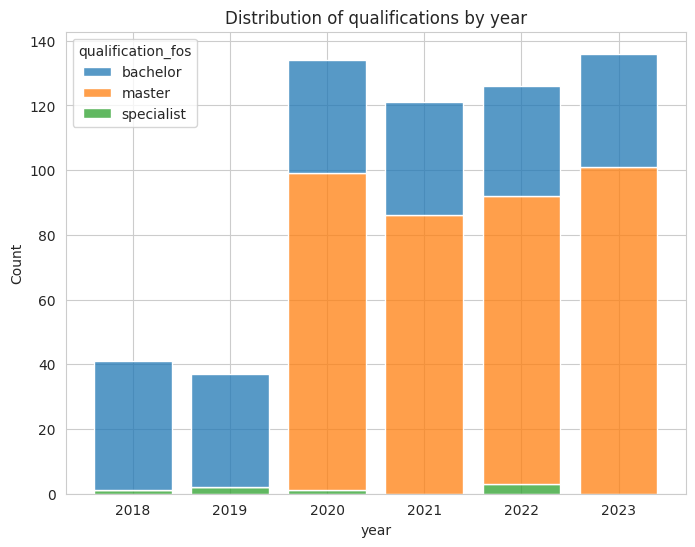

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(df, x='year', hue='qualification_fos', multiple='stack', discrete=True, shrink=.8).set(title='Distribution of qualifications by year')

**Heatmap по годам и структурным подразделениям**

Выводы:
1. Данные по годам и юнитам есть только с 2022 (по факту с 2023)
2. Топ-3 самых наполненных юнита: ФСУ и Р, ФПИ и КТ, ИПКН и ФТМИ
3. Существуют юниты лишь с 1 УП, возможно они открылись в 2023

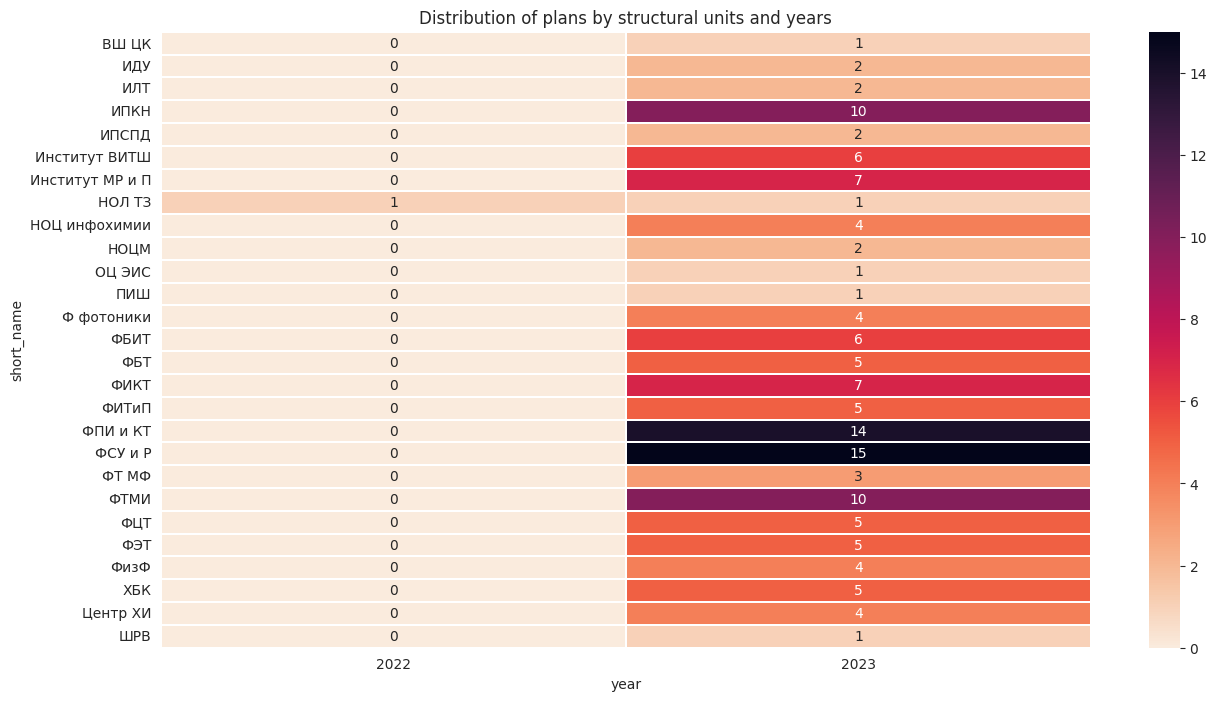

In [ ]:
df_heatmap = df.groupby(['year', 'short_name'])['id'].count().reset_index()

df_heatmap = df_heatmap.pivot('short_name', 'year', 'id')
df_heatmap = df_heatmap.fillna(0)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(df_heatmap, annot=True, linewidth=0.01, cmap='rocket_r', yticklabels=True).set(title='Distribution of plans by structural units and years')

**Восстановленный heatmap по годам и структурным подразделениям**

Выводы:
1. Можно отследить появление новых юнитов, например, в 2023 - ШВР
2. Институт ВИТШ потерял значительную часть УП после 2020
3. ФСУ и Р всегда был в лидерах по числу УП

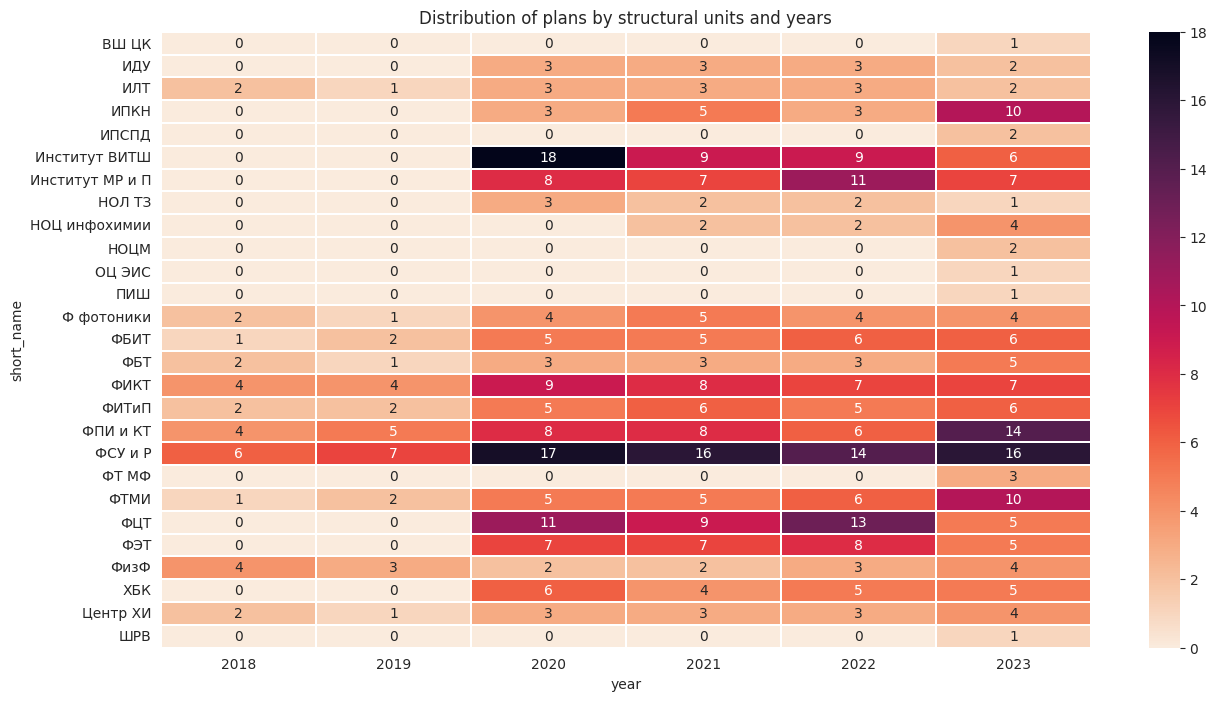

In [ ]:
temp_df = df.copy()
temp_df['short_name'] = temp_df.groupby(['number', 'field_of_study_id'])['short_name'].transform(lambda x: x.fillna(method='bfill'))

df_heatmap = temp_df.groupby(['year', 'short_name'])['id_ap_in_fos'].count().reset_index()
df_heatmap = df_heatmap.pivot('short_name', 'year', 'id_ap_in_fos')
df_heatmap = df_heatmap.fillna(0)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(df_heatmap, annot=True, linewidth=0.01, cmap='rocket_r', yticklabels=True).set(title='Distribution of plans by structural units and years')

**Нормированное распределение УП в юнитах с разбивкой по квалификации в 2023**

Выводы:
1. Есть только 1 юнит, у которого нет магистратуры - ШВР
2. Есть несколько юнитов, у которых нет бакалавриата

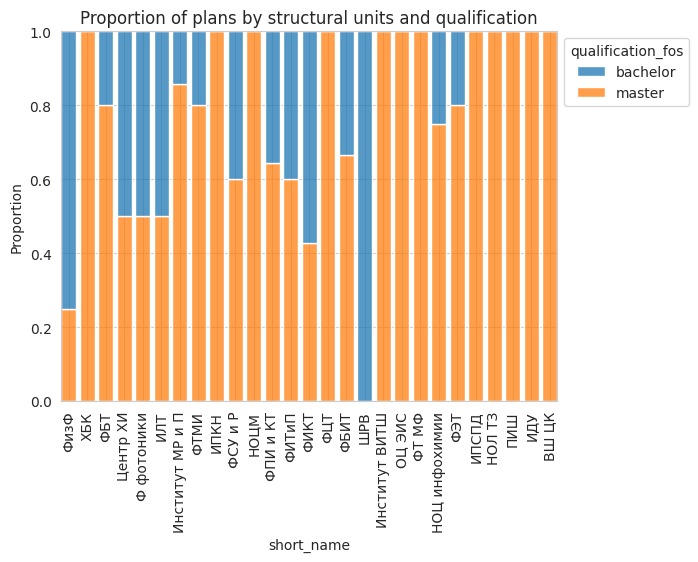

In [ ]:
temp_df = df[df['year'] == 2023]

ax = sns.histplot(
    data=temp_df,
    x="short_name", hue="qualification_fos",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Proportion of plans by structural units and qualification')
plt.xticks(rotation=90)
plt.show()

**Появление новых УП и закрытие старых по годам с разбивкой по квалификации**

Выводы:
1. Есть определенная ротация, то есть много УП открывается и закрывается
2. Специалитет долго не живет

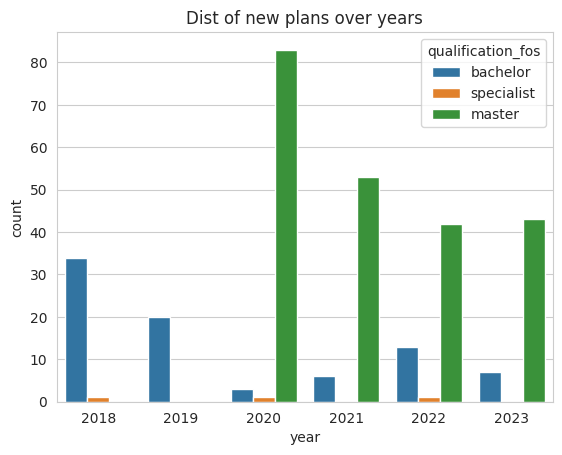

In [ ]:
temp_df = df.sort_values(by='year')
temp_df = temp_df.drop_duplicates(subset=['title_ap_in_fos', 'number'], keep='first')
temp_df = temp_df.reset_index()

sns.countplot(temp_df, x='year', hue='qualification_fos')

plt.title('Dist of new plans over years')

plt.show()

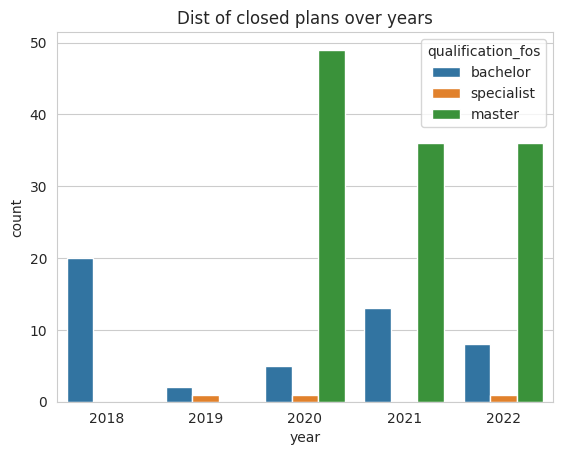

In [ ]:
temp_df = df.copy()
temp_df = temp_df.sort_values(['year'], ascending=True)
temp_df = temp_df.drop_duplicates(['title_ap_in_fos', 'number'], keep='last')
temp_df = temp_df[temp_df['year'] != 2023]

ax = sns.countplot(temp_df, x='year', hue='qualification_fos')

plt.title('Dist of closed plans over years')

plt.show()

## Задание 1.4 Анализ

1. Для планов 2023 года набора построить график с распределением статусов (on_check) по уровням образования.

2. Найдите планы со статусом проверенные ('verified') , у которых некорректная трудоемкость (laboriousness). Корректная трудоемкость для бакалавривата - 240, для магистратуры - 120.
Для таких планов выведите ИД плана (id плана всегда из 5 цифр), название структурного подразделения (structural unit -> title) и список редакторов (editors)

In [ ]:
df_filtered = pd.merge(data_extractor.dfs['academic_plans'], df, left_on='academic_plan_in_field_of_study_id', right_on='id_ap_in_fos', suffixes=('_ap', '__ap_in_fos' ))
df_filtered = df_filtered[df_filtered['year'] == 2023]

df_filtered.sample(5)

,id_ap,approval_date,ap_isu_id,laboriousness,on_check,was_send_to_isu,academic_plan_in_field_of_study_id,id_ap_in_fos,year,qualification_ap_in_fos,...,editors_id,structural_unit_id,number,id_fos,title_fos,qualification_fos,id__ap_in_fos,title,isu_id,short_name
539,7370,2022-11-30T20:04:17.656954Z,18442.0,120,verified,True,7434,7434,2023,master,...,"[936, 2454, 604, 1440, 4689, 28]",27.0,15.04.04,15770.0,Автоматизация технологических процессов и прои...,master,27.0,научно-образовательный центр инфохимии,638.0,НОЦ инфохимии
512,7364,2022-11-30T20:04:17.583234Z,18456.0,120,verified,True,7428,7428,2023,master,...,"[746, 1428, 14, 582, 2023]",34.0,12.04.04,15760.0,Биотехнические системы и технологии,master,34.0,центр химической инженерии,960.0,Центр ХИ
495,7328,2022-11-30T20:04:17.162345Z,18429.0,120,verified,True,7392,7392,2023,master,...,"[400, 315, 844]",51.0,01.04.02,15735.0,Прикладная математика и информатика,master,51.0,научно-образовательный центр математики,994.0,НОЦМ
595,7387,2022-11-30T20:04:17.869428Z,18412.0,120,verified,True,7451,7451,2023,master,...,"[746, 1428, 14, 582, 2023]",34.0,18.04.02,15779.0,Энерго- и ресурсосберегающие процессы в химиче...,master,34.0,центр химической инженерии,960.0,Центр ХИ
508,7366,2022-11-30T20:04:17.610197Z,18523.0,120,verified,True,7430,7430,2023,master,...,"[555, 2642]",33.0,12.04.05,15761.0,Лазерная техника и лазерные технологии,master,33.0,институт перспективных систем передачи данных,793.0,ИПСПД


График

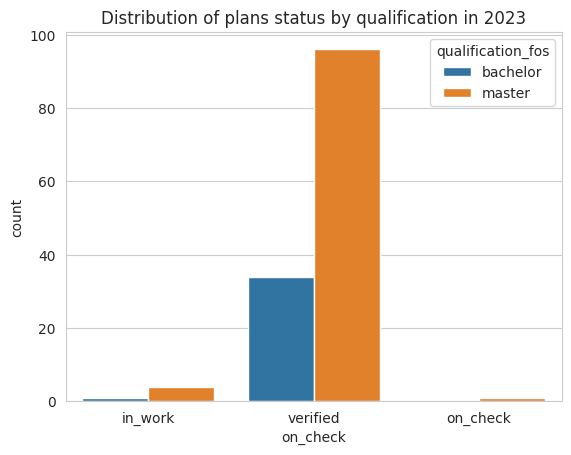

In [ ]:
ax = sns.countplot(df_filtered, x='on_check', hue='qualification_fos').set(title='Distribution of plans status by qualification in 2023')

plt.show()

Фильтрация

In [ ]:
from ast import literal_eval

In [ ]:
df_filtered_ = df_filtered[(df_filtered['on_check'] == 'verified') & (((df_filtered['qualification_fos'] == 'master') & (df_filtered['laboriousness'] != 120)) | ((df_filtered['qualification_fos'] == 'bachelor') & (df_filtered['laboriousness'] != 240)))]
df_filtered_ = df_filtered_[['ap_isu_id', 'title', 'editors_id']]
df_filtered_['editors_id'] = df_filtered_['editors_id'].apply(literal_eval)
df_filtered_ = df_filtered_.explode('editors_id')
df_filtered_ = pd.merge(df_filtered_, data_extractor.dfs['editors'], left_on='editors_id', right_on='id', suffixes=('_ap', '_editor'))
df_filtered_['editor_name'] = df_filtered_['first_name'] + ' ' + df_filtered_['last_name']

df_filtered_ = df_filtered_.groupby(['ap_isu_id', 'title']).agg({'editor_name': lambda x: ', '.join(x)}).reset_index()
df_filtered_['ap_isu_id'] = df_filtered_['ap_isu_id'].astype(int)
df_filtered_.set_index('ap_isu_id')

,title,editor_name
ap_isu_id,,
18339,факультет информационных технологий и программ...,"Мария Приз, Екатерина Колесник, Андрей Станкев..."
18340,факультет экотехнологий,"Анастасия Токарева, Анна Маненкова, Дарья Плуж..."
18343,факультет инфокоммуникационных технологий,"Мария Приз, Марина Говорова, Александра Ватьян"
18361,научно-образовательный центр инфохимии,"Полина Зырянова, Анна Стекольщикова, Анастасия..."
18362,факультет биотехнологий,"Анастасия Кузнецова, Алла Наумова, Ольга Сосни..."
18366,институт международного развития и партнерства,"Анастасия Токарева, Наталия Горлушкина, Верони..."
18397,институт международного развития и партнерства,"Мария Росс, Татьяна Букарева, Алия Сахариева"
18405,факультет биотехнологий,"Анастасия Кузнецова, Алла Наумова, Ольга Сосни..."
18407,факультет биотехнологий,"Алла Наумова, Ольга Соснина, Мария Росс"


# Критерии и баллы

Распределение исходя из 30 баллов.



*   1.0 - 1 балл
*   1.1 - 3 балла
*   1.2 - 6 баллов
*   1.3 - 10 баллов
*   1.4 - 10 баллов

